# The Impact of Ambient Temperature on Server Efficiency


Hypothesis: Server power consumption increases as temperature increases reducing server efficiency. As PUE values approach 1 an increasing portion of the Data centre's power is used in the server therfore there is likely to be a trade-off on operating temperature depending on cooling infrastructure and number of servers in the datacenter. 

------

Plan:

- Load in all of the SERT results avoiding any invalid ones
- Merge data as needed 
- Generate graphs showing power consumption against load and temperature
- Find a trade-off between operating temperature and number of servers. 


In [ ]:
import numpy as np
import pandas as pd
import re
from pathlib import Path
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from parse_results import process_results_xml
import yaml
#import influxdb_client

In [ ]:
settings_file = Path('settings.yaml')

if settings_file.exists():
    with settings_file.open() as f:
        params = yaml.load(f, Loader=yaml.FullLoader)
else:
    params = {}
    
sert_results_dir = params.get('results_dir', 'sert_results')
bios_setting_file = params.get('test_settings', 'test_settings.csv')
cpu_metrics_dir = params.get('cpu_metrics_dir', 'cpu_data')

working_dir_path = params.get('temp_dir', 'temp_dir')
all_data_file = params.get('data_file', 'all_data.csv')
overwrite_data = params.get('overwrite_data', False)

whitelist = params.get('whitelist', '')

working_dir = Path(working_dir_path)

# Generate and load the data (Run Once)

In [ ]:
def aggregate_sert(file, test_name, test_details, params):
    # Load the SERT result
    metrics, score, env = process_results_xml(f)
    
    # METRICS
    metrics_df = pd.DataFrame.from_records(metrics)
    # Remove calibration runs but record the calibration score against each loadlevel to calculate actual loadlevel
    calibrations = metrics_df.loc[metrics_df['loadlevel']=='calibration', ['worklet', 'score']]
    calibrations = calibrations.rename(columns={'score': 'calibration-score'})

    metrics_df = pd.merge(metrics_df.drop(index=calibrations.index), calibrations, how='left', on='worklet')
    metrics_df['actual-load'] = metrics_df['score'] / metrics_df['calibration-score']
    metrics_df.loc[metrics_df['workload'] == 'Idle', 'actual-load'] = 0
    metrics_df['test-name'] = test_name
    
    if test_details['location'].get(test_name) == 'Tunnel':
        if 'influxdb' in params:
            metrics_df['pressure'] = get_tunnel_pressure(metrics_df, params)
        else:
            # Can't get tunnel data without influx credentials
            metrics_df['pressure'] = np.nan
    else:
        metrics_df['pressure'] = 0.0

    # SCORE
    score_df = pd.DataFrame.from_records(score)
    score_df['test-name'] = test_name
    
    # ENV
    env_df = pd.DataFrame.from_records(env, index=[test_name])
    # Test details are "unknwon" if not in the test_details csv
    env_df['location'] = test_details['location'].get(test_name, 'unknown')
    env_df['bios'] = test_details['bios'].get(test_name, 'unknown')
    
    return metrics_df, env_df, score_df
    
def get_tunnel_pressure(metrics, params):
    from influxdb import InfluxDBClient
    client = InfluxDBClient(host=params['influxdb']['host'], 
                            port=params['influxdb']['port'], 
                            username=params['influxdb']['user'], 
                            password=params['influxdb']['password'],
                            database=params['influxdb']['tunnel-database'])
    
    return metrics.apply(get_pressure_row,  axis=1, client=client)
    
def get_pressure_row(r, client):
    query = f'select (mean("value")-21.65)*62/19 from sensors where "channel"=\'Pressure\' and time>=\'{r.start.isoformat()}\' and time<=\'{r.end.isoformat()}\''
    result = client.query(query)
    for pt in result.get_points('sensors'):
        return pt['mean']

    return np.nan # Tunnel run but no data    
    

# Ensure the working directory exists
if not working_dir.exists():
    working_dir.mkdir(parents=True)

# Temp files
metrics_path = working_dir.joinpath('metrics.csv')
scores_path = working_dir.joinpath('scores.csv')
details_path = working_dir.joinpath('test_details.csv')

    
# Load any existing chached data or start empty if they don't exist
if working_dir.joinpath('metrics.csv').exists() and not overwrite_data:
    print('Loading SERT data from disk')
    try:
        metrics_data = pd.read_csv(str(metrics_path), parse_dates=['start', 'end'])
        scores = pd.read_csv(str(scores_path))
        test_details = pd.read_csv(str(details_path), index_col=0)
    except Exception as e:
        print('Reloading failed, exception: ', e, '\nRebuilding...')
        metrics_data = pd.DataFrame()
        test_details = pd.DataFrame()
        scores = pd.DataFrame()
else:
    print('Rebuilding SERT results data.....')
    metrics_data = pd.DataFrame()
    test_details = pd.DataFrame()
    scores = pd.DataFrame()

# Load external details for test
if bios_setting_file != '' and Path(bios_setting_file).is_file():
    settings = pd.read_csv(bios_setting_file, index_col=0)
else:
    settings = pd.DataFrame(columns=['location', 'bios'])
    
# Find any results in the results directory that aren't already in the dataframes, but only look for results that are valid or in the whitelist
source_path = Path(sert_results_dir)
new_results = [x for x in source_path.glob('**//results.xml') if x.parent.name not in test_details.index and 
                                                               (not x.parent.joinpath('invalid.png').exists() or x.parent.name in whitelist)]

for f in new_results:     
    try:
        metrics, details, score = aggregate_sert(str(f), f.parent.name, settings, params)

        metrics_data = metrics_data.append(metrics, ignore_index=True)
        test_details = test_details.append(details)
        scores = scores.append(score, ignore_index=True)

    except Exception as e:
        print(f, ': FAILED TO LOAD -- ', e, type(e))

        
# Store the new metrics
if len(new_results) > 0:
    # Store generated data
    metrics_data.to_csv(str(metrics_path), index=False)
    test_details.to_csv(str(details_path))
    scores.to_csv(str(scores_path), index=False)

In [ ]:
# Set this to True if you haven't run the previous cell and want to just load the data from last time.
reload_from_cached = False

data_cache_path = working_dir.joinpath(all_data_file)

if reload_from_cached and data_cache_path.exists():
    sert_data = pd.read_csv(str(data_cache_path), parse_dates=['start', 'end'])
else:        
    # Build the combined view for analysis

    # Join metrics, test details and scores into a big view table
    sert_data = pd.merge(metrics, scores[['test-name', 'worklet', 'loadlevel', 'norm-score', 'ref-score', 'efficiency-score']], how='left', on=['test-name', 'worklet', 'loadlevel'])
    sert_data = pd.merge(sert_data, test_details, left_on='test-name', right_index=True)

    # Scenario column for easier display and filtering
    sert_data['scenario'] = list(' - '.join(s) for s in zip(sert_data['model'], sert_data['cpu']))

    # Drop any tests that were run without hyperthreading
    sert_data.drop(sert_data[sert_data.logical_cores == sert_data.physical_cores].index, inplace=True)
    
    # Save a cache of the joins
    sert_data.to_csv(str(data_cache_path), index=False)

In [ ]:
sert_data.head()    

In [ ]:
sert_data.describe()

In [ ]:
#test_details
total_score = scores[scores['workload'] == 'All'].dropna(axis=1)
total_score = total_score.merge(test_details, left_on='test-name', right_index=True, how='left').dropna()
total_score['scenario'] = list(' - '.join(x) for x in zip(total_score['model'], total_score['cpu']))
total_score['temperature'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-avg'].mean(), axis=1)
total_score['temperature-range'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['temp-max'].max() - sert_data[sert_data['test-name'] == row['test-name']]['temp-min'].min(), axis=1)
total_score = total_score.merge(sert_data[sert_data['workload'] == 'Idle'][['watts-avg','test-name']], left_on='test-name', right_on='test-name').rename(columns={'watts-avg':'idle-power'})
total_score['max-power'] = total_score.apply(lambda row: sert_data[(sert_data['test-name'] == row['test-name']) & (sert_data['loadlevel']=='100%')]['watts-avg'].mean(), axis=1)
total_score['pressure'] = total_score.apply(lambda row: sert_data[sert_data['test-name'] == row['test-name']]['pressure'].mean(), axis=1)
total_score

# What scenarios have been tested?
Using a 3 bin strategy for temperature testing and high and low for pressure.

In [ ]:
tested = total_score.groupby(['scenario', 'bios', pd.cut(total_score.pressure, [total_score.pressure.min(), 15, total_score.pressure.max()]), pd.cut(total_score.temperature,[20, 23.5,27.5, 30])]).size().unstack().unstack()
tested.style.applymap(lambda x: 'background-color:pink' if x < 3 else None)

In [ ]:
print('Mean\n', sert_data.groupby('scenario')['temp-avg'].mean())
print('\nVariance\n', sert_data.groupby('scenario')['temp-avg'].var())
sns.displot(data=sert_data, x="temp-avg", hue="scenario", kde=True, fill=False)

In [ ]:
sns.displot(data=sert_data, x="pressure", hue="scenario", kde=True, fill=False)

In [ ]:
print(list(sert_data[sert_data.logical_cores == sert_data.physical_cores]['test-name'].unique()), list(sert_data[sert_data.logical_cores == sert_data.physical_cores]['bios'].unique()))

# Effects on overall SERT score

# Efficiency and power consumption measured by SERT

For the CPU workelts in particular, we can plot the benchmark load against the efficiency score achevied for each scenario. 

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]

sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.5], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Efficiency Scores', y=1.1)
sns.lmplot(x='actual-load', y='watts-avg', hue='scenario', col='bios', 
           data=cpu[cpu['temp-avg'] < 23.5], order=2, truncate=True, scatter=True).fig.suptitle('CPU Worklet Power Consumption', y=1.1)

A cleaner plot without the individual data plotted for each sert run. 

In [ ]:
sns.lmplot(x='actual-load', y='efficiency-score', hue='scenario', data=cpu[cpu['temp-avg'] < 22.5], order=2, truncate=True, scatter=False)
ax = plt.gca()
ax.set_title('CPU Worklet Efficiency Scores ( Test Temperature < 22.5C)')

The environmental conditions for the tests are as follows:

# The Effect of Temperature
The overall efficiency score across various temperatures

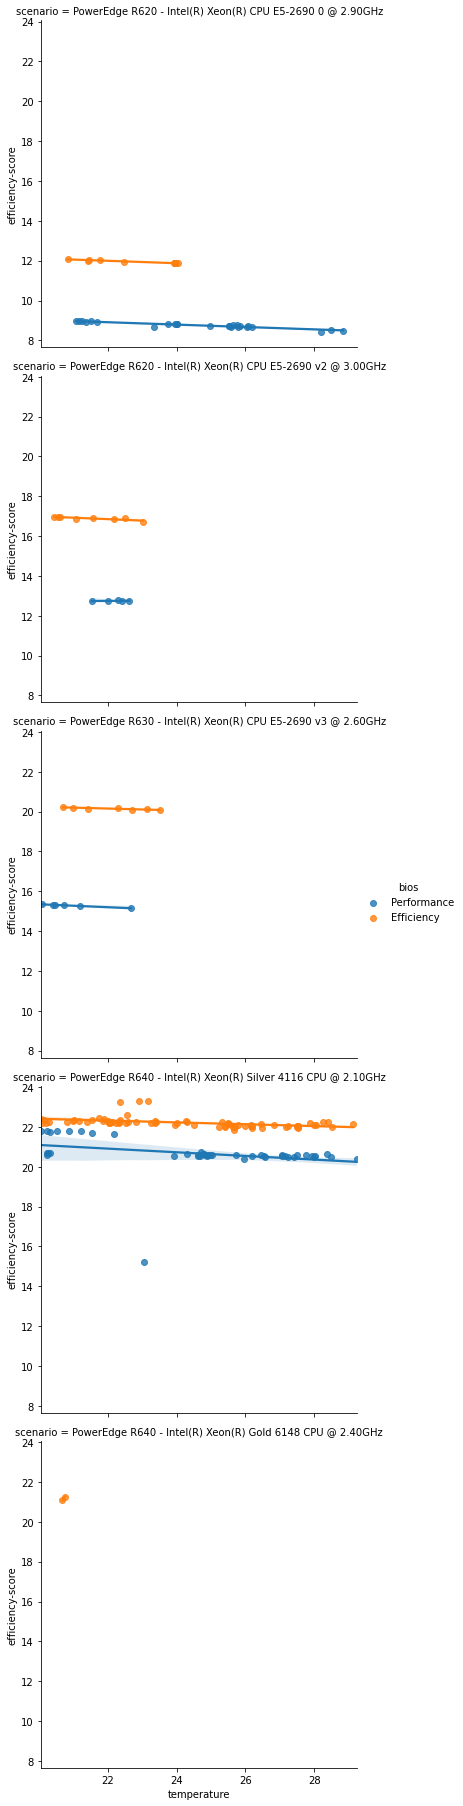

In [ ]:
sns.lmplot(data=total_score, x='temperature', y='efficiency-score', hue='bios', row='scenario')

In [ ]:
total_score[total_score['temperature'] < 22].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()


In [ ]:
total_score[total_score['temperature'] > 28].groupby(['scenario', 'bios'])[['efficiency-score', 'temperature', 'idle-power', 'max-power']].mean()

In [ ]:
cpu[(cpu['loadlevel'] == '100%')].groupby([ 'worklet','scenario', 'bios'])['norm-score'].mean().unstack().pct_change(axis=1).abs().mean()

In [ ]:
cpu[(cpu.model == 'PowerEdge R640') & (cpu.worklet == 'CryptoAES') & (cpu.loadlevel == '100%')].groupby('bios')['norm-score'].mean()

In [ ]:
cpu[['worklet', 'loadlevel', 'scenario', 'bios', 'score']].groupby(['scenario', 'bios', 'worklet', 'loadlevel']).mean()

# CPU Power

The CPU is usually considered the driver of most power consumption in the server (excluding any expansion cards). During the SERT tests we have also recorded low-level performance registers of the CPU like per-core frequency and also power consumption. 

Todo: 
- Determine relationship between chassis and CPU power consumption
    - Assume power = P_Idle + P_Chassis + P_CPU
    - IS P_Chassis a function of CPU power?
    
    
Read the CPU power data in and summarise for the tests

In [ ]:
cpu_metrics = pd.DataFrame()

if not os.path.exists(f'{working_dir}//cpu_metrics.csv') or overwrite_data :
    
    for f in glob.glob(f'{cpu_metrics_dir}//**.csv', recursive=True):
        try:
            samples = pd.read_csv(f, skiprows=8, header=0, index_col=0, parse_dates=['Time'], encoding='cp1252')
            if not pd.api.types.is_datetime64_any_dtype(samples.index.dtype):
                # Final row contains "Session end:"
                samples.drop('Session end:', inplace=True)
                samples.index = pd.to_datetime(samples.index)

            cpu_metrics = cpu_metrics.append(samples)
        except:
            print(f'FAILED LOADING FILE: {f}')

    cpu_metrics.sort_index(inplace=True)
    cpu_metrics['total cpu power'] = cpu_metrics['CPU 0 Power'] + cpu_metrics['CPU 1 Power']
    
    cpu_metrics.to_csv(f'{working_dir}//cpu_metrics.csv')
    
else:
    cpu_metrics = pd.read_csv(f'{working_dir}//cpu_metrics.csv', index_col='Time', parse_dates=['Time'])
    

In [ ]:
cpu_metrics['avg-temp'] = cpu_metrics.filter(regex='Temp').mean(axis=1, skipna=True)
cpu_metrics['avg-load'] = cpu_metrics.filter(regex='load').mean(axis=1, skipna=True)
cpu_metrics['avg-freq'] = cpu_metrics.filter(regex='speed').mean(axis=1, skipna=True)


#pd.to_datetime(cpu_metrics['Time']
sert_data['cpu-power'] = sert_data.apply(lambda row: cpu_metrics['total cpu power'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['chassis-power'] = sert_data['watts-avg'] - sert_data['cpu-power']

sert_data['cpu-temp'] = sert_data.apply(lambda row: cpu_metrics['avg-temp'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-load'] = sert_data.apply(lambda row: cpu_metrics['avg-load'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)
sert_data['cpu-freq'] = sert_data.apply(lambda row: cpu_metrics['avg-freq'][row['start'].tz_localize(None):row['end'].tz_localize(None)].mean(), axis=1)



Looking again at the server efficiency scores, but now using the CPU utilsiation dat from the OS rather than the load data calculated by SERT. SERT load is a proportion of the total score/transactions acheived during the calibration runs. OS CPU utilisaiton is the proportion of time the CPU is busy performing operations. 

In [ ]:
cpu_worklets = sert_data[(sert_data['workload'] == 'Idle') | (sert_data['workload'] == 'CPU')]
cpu_worklets['scenario'] = list(' - '.join(x) for x in zip(cpu_worklets['model'], cpu_worklets['cpu']))
sns.lmplot(x='cpu-load', y='efficiency-score', hue='scenario', col='bios', data=cpu_worklets[cpu_worklets['temp-avg'] < 22.5], order=2, truncate=True, scatter=True).fig.suptitle('Efficiency Scores ( Test Temperature < 22.5C)', y=1.1)


This is a significantly different relationship than that shown for the SERT load. 

Breaking down the performance per server and per worklet.

In [ ]:

    sns.lmplot(x='cpu-load', y='watts-avg', hue='worklet', col='bios', row='scenario', data=cpu_worklets, order=1, truncate=True, scatter=True).fig.suptitle(f'Efficiency Scores', y=1.1)


In [ ]:
sns.lmplot(x='temp-avg', y='efficiency-score', hue='scenario', data=cpu_worklets, order=1, scatter=False)

# CPU power consumption

In [ ]:
plotdf = cpu_worklets.melt('actual-load', ['watts-avg', 'cpu-power', 'chassis-power'])

sns.lmplot(x='actual-load', y='value', hue='variable', data=plotdf, order=2)

In [ ]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['actual-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

In [ ]:
for server in cpu_worklets['scenario'].unique():
    plotdf = cpu_worklets[cpu_worklets['scenario'] == server].melt(['cpu-load', 'bios'], ['watts-avg', 'cpu-power', 'chassis-power'])

    sns.lmplot(x='actual-load', y='value', col='bios', hue='variable', data=plotdf, order=2).fig.suptitle(f'Power Breakdown - {server}', y=1.1)

KeyError: "['actual-load'] not in index"

In [ ]:
for worklet in sert_data[sert_data['workload'] == 'CPU']['worklet'].unique():
    sns.lmplot(data=sert_data[(sert_data['worklet'] == worklet) | (sert_data['workload'] == 'Idle')], x='actual-load', y='cpu-load', hue='scenario', col='bios', order=2).fig.suptitle(f'Server load vs CPU utilisaiton - {worklet}', y=1.1)

In [ ]:
cpu = sert_data[(sert_data['workload'] == 'CPU')| (sert_data['workload'] == 'Idle')]
cpu = cpu[cpu['model'] == 'PowerEdge R620']
#cpu = cpu[cpu['cpu'].str.contains('E5-2690 0')]


#sns.lmplot(x='cpu-power', y='chassis-power', hue='worklet', data=cpu, order=2)
sns.scatterplot(x='temp-avg', y='watts-avg', hue='cpu', data=cpu)

In [ ]:
sns.lmplot(x='cpu-load', y='cpu-power', data=cpu, order=2)

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['temp-avg'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Ambient Temp', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

In [ ]:
ax = plt.scatter(x=cpu['cpu-temp'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Temp')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')

In [ ]:
ax = plt.scatter(x=cpu['cpu-freq'], y=cpu['cpu-power'], c=cpu['cpu-load'])
cbar = plt.colorbar()
cbar.ax.set_ylabel('CPU Load', rotation=90)
plt.ylabel('CPU Power')
plt.xlabel('CPU Freq')
plt.title('R620 E5-2690, Efficiency (DPAC) Mode')